# KFold-VGG16-PetsHI(BreasKHist weights)

---



Instituto Federal de Educação, Ciência e Tecnologia do Maranhão.

Aluno: Vinícius Barbosa Da Silva

Matrícula: 20181SI0007

Orientador: Omar Andres Carmona Cortes

Projeto: Uma Base de Dados para Identificação de Câncer em PETs Usando Aprendizagem Profunda

---



O conjunto de dados possui 592 imagens totais divididas em benign(mama normal) = 220 e malignant(neoplasia) = 372. o conjunto foi aumentado em 10x as imagens de benign e 5x as imagens de malignant com as transformações: flip vertical, flip horizontal e random crop(0, 100).

Neste Notebook foi feito o 2 Kfold no modelo VGG16, um sem pesos pré-treinados BreakHis, outro com pesos pré-treinados do BreasKHis. Na utilização do modelo pré treinado BreakHis há um double transfer learning no qual a VGG16 usa pesos do imagenet e depois do BreasKHis com ajuste fino para congelar camadas. Com K = 5.



---



## Import das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.backend import clear_session

import sklearn
from sklearn.model_selection import KFold, train_test_split


import pathlib
import os

## Extraindo PATH e LABELS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

path = '/content/drive/MyDrive/Base de dados de HI Pets.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
data_path = pathlib.Path(r'/content/Base de dados de HI Pets')

# glob all 'jpg' image files
img_path = list(data_path.glob('**/*.jpg'))

# split label names do diretório
img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

In [ ]:
# Criar um DataFrame
pd_img_path = pd.Series(img_path, name='PATH').astype(str)
pd_img_labels = pd.Series(img_labels, name='LABELS').astype(str)
img_df = pd.merge(pd_img_path, pd_img_labels, right_index=True, left_index=True)

# Amostras aleatórias
img_df = img_df.sample(frac=1).reset_index(drop=True)

# Mostrar as primeiras linhas do DataFrame após a transformação
img_df.head()

,PATH,LABELS
0,/content/Base de dados de HI Pets/malignant/cl...,malignant
1,/content/Base de dados de HI Pets/malignant/cl...,malignant
2,/content/Base de dados de HI Pets/malignant/cl...,malignant
3,/content/Base de dados de HI Pets/malignant/cl...,malignant
4,/content/Base de dados de HI Pets/benign/class...,benign


In [ ]:
img_df['LABELS'].value_counts(ascending=True)


benign       220
malignant    372
Name: LABELS, dtype: int64

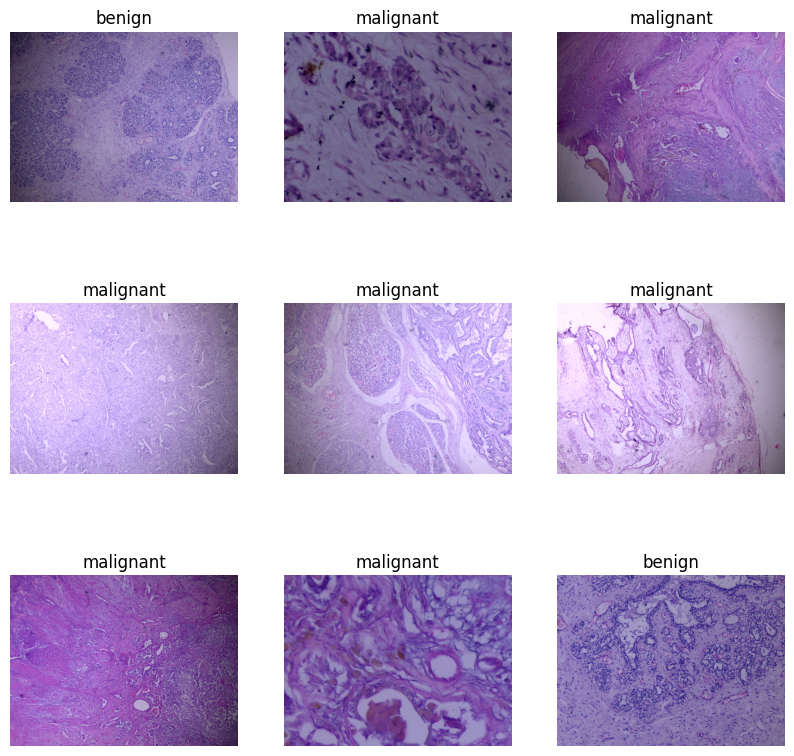

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img_df.PATH[i]))
  plt.title(img_df.LABELS[i])
  plt.axis("off")

## Dividindo em Teste e Treino

In [ ]:
train_dataset, test_dataset = train_test_split(img_df, train_size=0.8, shuffle=True, stratify=img_df['LABELS'])
print("Number of train data:", train_dataset.shape[0])
print("Number of test data:", test_dataset.shape[0])

Number of train data: 473
Number of test data: 119


In [ ]:
train_dataset

,PATH,LABELS
369,/content/Base de dados de HI Pets/malignant/cl...,malignant
479,/content/Base de dados de HI Pets/malignant/cl...,malignant
376,/content/Base de dados de HI Pets/malignant/cl...,malignant
579,/content/Base de dados de HI Pets/malignant/cl...,malignant
549,/content/Base de dados de HI Pets/malignant/cl...,malignant
...,...,...
172,/content/Base de dados de HI Pets/benign/class...,benign
266,/content/Base de dados de HI Pets/malignant/cl...,malignant
383,/content/Base de dados de HI Pets/malignant/cl...,malignant
99,/content/Base de dados de HI Pets/malignant/cl...,malignant


## Data Augmentation

In [ ]:

width = 224
height = 224
batch_size = 32

gerador_treinamento = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


## Teste

In [ ]:
test_gen = ImageDataGenerator(rescale=1/255.0)
test_ds = test_gen.flow_from_dataframe(test_dataset,
                                       x_col='PATH', y_col='LABELS',
                                       target_size=(224,224),
                                       class_mode = 'binary',
                                       color_mode = 'rgb',
                                       batch_size = 16,
                                       shuffle=False)

Found 119 validated image filenames belonging to 2 classes.


## Funções de métricas

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(histories, test_ds):
    # Para cada fold
    for fold, history in enumerate(histories, start=1):
        print(f"Fold {fold}:")

        # Prever as classes no conjunto de teste
        test_predictions = history.model.predict(test_ds)

        test_predictions_binary = (test_predictions > 0.5).astype(int)

        y_test = test_ds.labels

        accuracy = accuracy_score(y_test, test_predictions_binary)
        print(f"Accuracy: {accuracy:.2f}")

        class_names = list(test_ds.class_indices.keys())

        report = classification_report(y_test, test_predictions_binary, target_names=class_names)
        print("Classification Report:\n", report)


        confusion = confusion_matrix(y_test, test_predictions_binary)

        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

        print("\n")


Plot da curva ROC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc_curves(histories, test_ds):
    fig1 = plt.figure(figsize=[12, 12])
    ax1 = fig1.add_subplot(111, aspect='equal')

    ax1.arrow(0.45, 0.5, -0.25, 0.25, width=0.02, color='green', alpha=0.5)
    ax1.arrow(0.5, 0.45, 0.25, -0.25, width=0.02, color='red', alpha=0.5)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, history in enumerate(histories):
        test_predictions = history.model.predict(test_ds)

        fpr, tpr, _ = roc_curve(test_ds.labels, test_predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i + 1, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % mean_auc, lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.text(0.32, 0.7, 'More accurate area', fontsize=12)
    plt.text(0.63, 0.4, 'Less accurate area', fontsize=12)
    plt.show()

## Sem Pesos BreakHis

### Model VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def create_model():
    # Carregar modelo pré-treinado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Congelar as camadas do modelo pré-treinado
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))


    # Compilar o modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

    return model


### Kfold

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
EPOCHS = 5
histories_model_imagenet = []

kfold = KFold(5, shuffle=True, random_state=123)

for f, (trn_ind, val_ind) in enumerate(kfold.split(train_dataset)):

    print();
    print("#"*50)
    print("Fold: ",f+1)
    print("#"*50)

    training_data = train_dataset.iloc[trn_ind]
    validation_data = train_dataset.iloc[val_ind]

    train_ds = gerador_treinamento.flow_from_dataframe(training_data,
                                            x_col='PATH', y_col='LABELS',
                                            target_size=(width,height),
                                            class_mode = 'binary', color_mode = 'rgb',
                                            batch_size = 32, shuffle = True)
    val_ds = gerador_treinamento.flow_from_dataframe(validation_data,
                                        x_col='PATH', y_col='LABELS',
                                        target_size=(width,height),
                                        class_mode = 'binary', color_mode = 'rgb',
                                        batch_size = 32, shuffle = False)


    model1 = create_model()

	# CREATE CALLBACKS
	# Criar o callback ModelCheckpoint
    checkpoint = ModelCheckpoint(filepath=f'model_wimagenet_checkpoint_fold_{f}.h5',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 mode='max',
                                 verbose=1)
    callbacks_list = [checkpoint]


    # Treinar o modelo
    history = model1.fit(
    train_ds,
    steps_per_epoch=train_ds.samples // batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    validation_data=val_ds,
    validation_steps=val_ds.samples // batch_size
    )

    # store history pra cada folds
    histories_model_imagenet.append(history)

    clear_session()



##################################################
Fold:  1
##################################################
Found 378 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.
58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 2.1408 - accuracy: 0.7023 - precision: 0.7588 - recall: 0.7828 - auc: 0.7099
Epoch 1: val_accuracy improved from -inf to 0.79688, saving model to model_wimagenet_checkpoint_fold_0.h5
11/11 [==============================] - 48s 3s/step - loss: 2.1408 - accuracy: 0.7023 - precision: 0.7588 - recall: 0.7828 - auc: 0.7099 - val_loss: 0.3381 - val_accuracy: 0.7969 - val_precision: 0.8182 - val_recall: 0.9375 - val_auc: 0.8984
Epoch 2/5
11/11 [==============================] - ETA: 0s - loss: 1.0415 - accuracy: 0.7543 - precision: 0.8091 - recall: 0.8054 - auc: 0.8233
Epoch 2: val_accuracy did not improve from 0.79688
11/11 [=========

### Métricas de cada FOLD

Fold 1:
8/8 [==============================] - 10s 898ms/step
Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

      benign       0.80      0.89      0.84        44
   malignant       0.93      0.87      0.90        75

    accuracy                           0.87       119
   macro avg       0.86      0.88      0.87       119
weighted avg       0.88      0.87      0.88       119



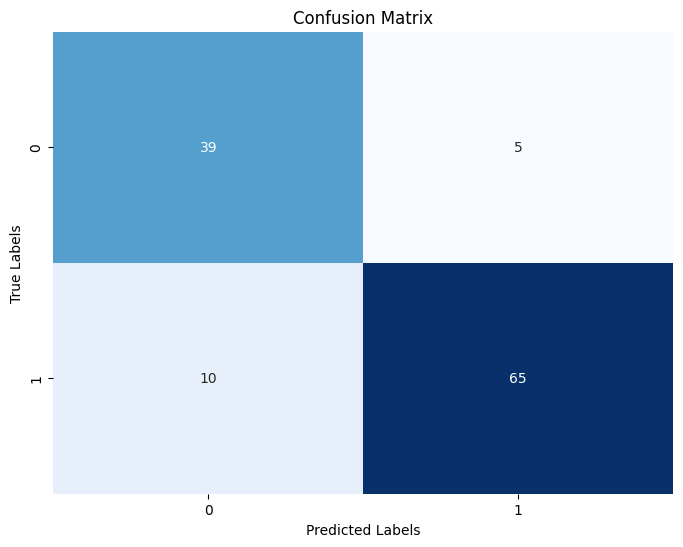



Fold 2:
8/8 [==============================] - 4s 518ms/step
Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

      benign       0.70      1.00      0.82        44
   malignant       1.00      0.75      0.85        75

    accuracy                           0.84       119
   macro avg       0.85      0.87      0.84       119
weighted avg       0.89      0.84      0.84       119



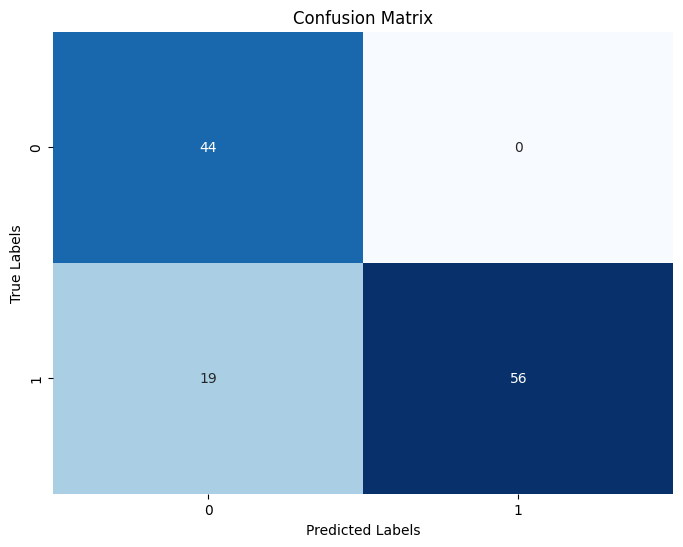



Fold 3:
8/8 [==============================] - 6s 690ms/step
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

      benign       0.88      0.98      0.92        44
   malignant       0.99      0.92      0.95        75

    accuracy                           0.94       119
   macro avg       0.93      0.95      0.94       119
weighted avg       0.95      0.94      0.94       119



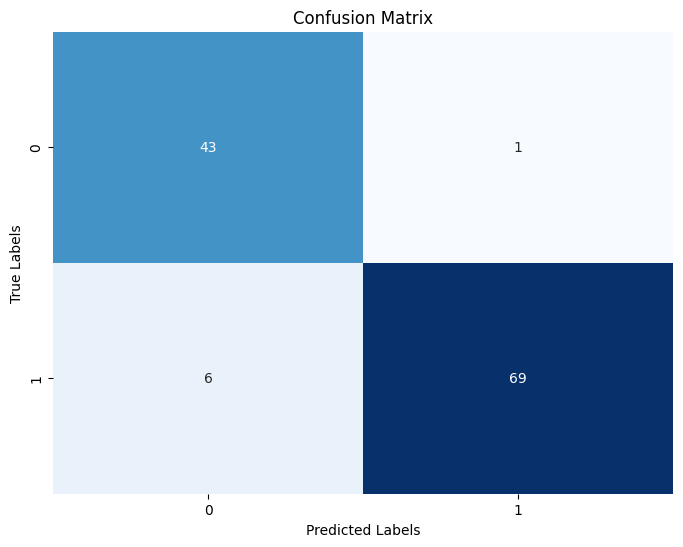



Fold 4:
8/8 [==============================] - 4s 520ms/step
Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

      benign       0.76      1.00      0.86        44
   malignant       1.00      0.81      0.90        75

    accuracy                           0.88       119
   macro avg       0.88      0.91      0.88       119
weighted avg       0.91      0.88      0.88       119



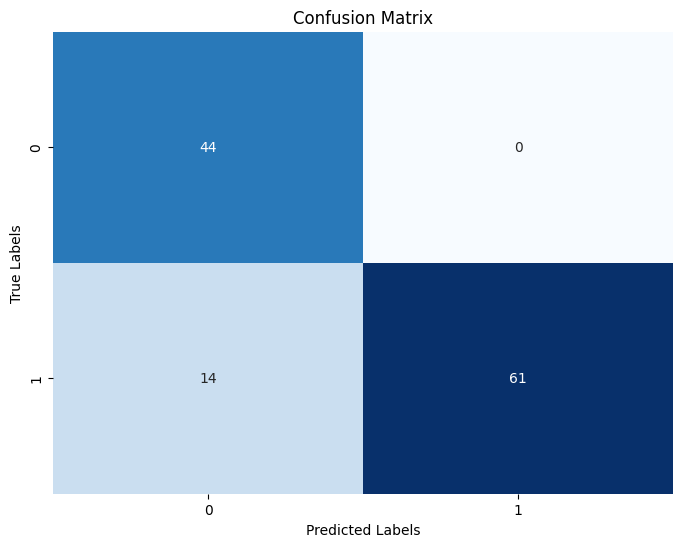



Fold 5:
8/8 [==============================] - 5s 599ms/step
Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

      benign       0.84      0.95      0.89        44
   malignant       0.97      0.89      0.93        75

    accuracy                           0.92       119
   macro avg       0.91      0.92      0.91       119
weighted avg       0.92      0.92      0.92       119



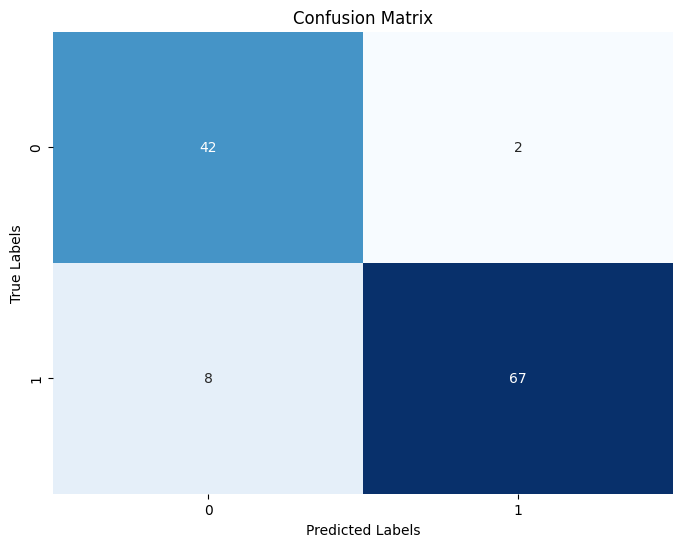

In [ ]:
evaluate_and_plot(histories_model_imagenet, test_ds)

### Plot da curva ROC

8/8 [==============================] - 5s 596ms/step


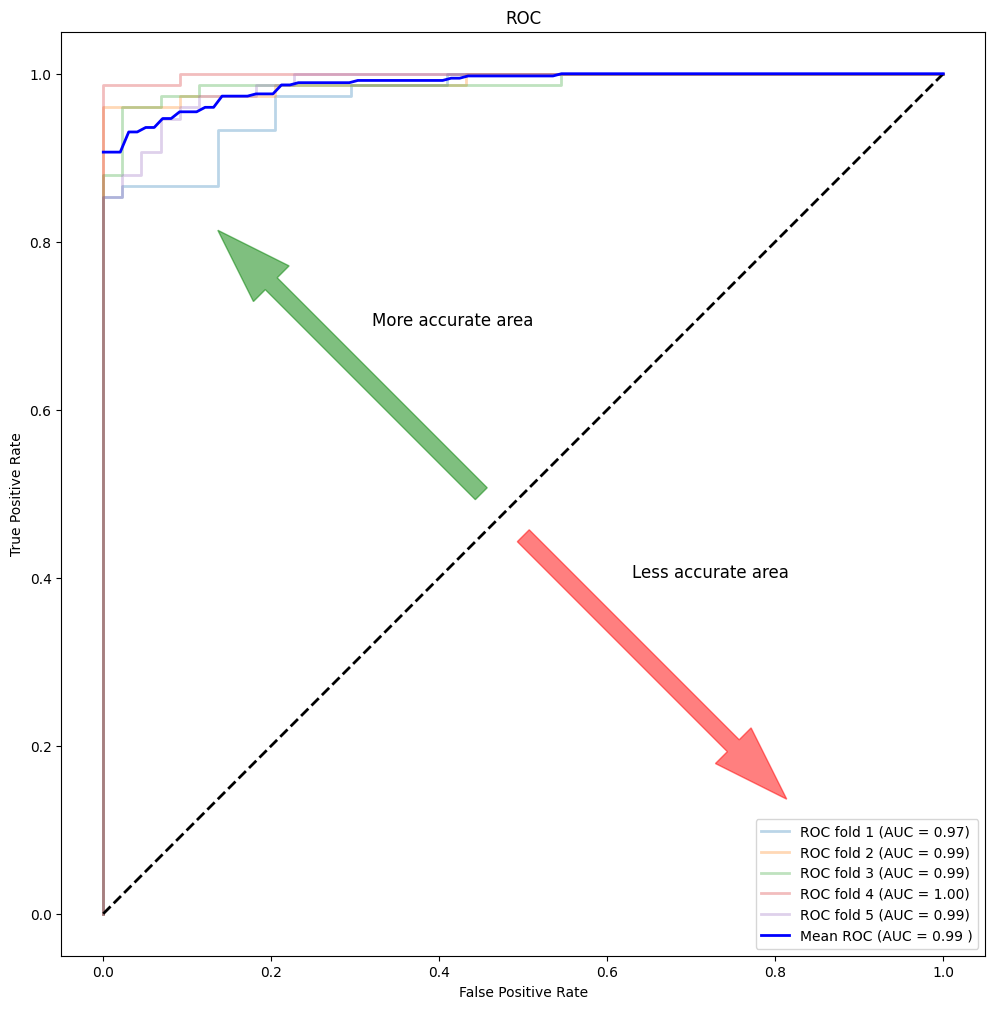

In [ ]:
plot_roc_curves(histories_model_imagenet, test_ds)

## Com Pesos BreaKHis

### Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def create_transfer_mode_weightsBreaKHis(weights_path):
    # Carregar modelo pré-treinado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Congelar as camadas do modelo pré-treinado
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))

    base_model.load_weights(weights_path, by_name=True)

    # Compilar o modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

    return model


### Pesos

In [ ]:
# Caminho para o arquivo .h5 com os pesos pré-treinados
weights_path = '/content/drive/MyDrive/vgg16_BreaKHis_model2.h5'

### Kfold

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
EPOCHS = 5
histories_model_weights_breakhis = []

kfold = KFold(5, shuffle=True, random_state=123)

for f, (trn_ind2, val_ind2) in enumerate(kfold.split(train_dataset)):

    print();
    print("#"*50)
    print("Fold: ",f+1)
    print("#"*50)

    training_data = train_dataset.iloc[trn_ind]
    validation_data = train_dataset.iloc[val_ind]

    train_ds2 = gerador_treinamento.flow_from_dataframe(training_data,
                                            x_col='PATH', y_col='LABELS',
                                            target_size=(width,height),
                                            class_mode = 'binary', color_mode = 'rgb',
                                            batch_size = 32, shuffle = True)
    print(train_ds.class_indices)
    val_ds2 = gerador_treinamento.flow_from_dataframe(validation_data,
                                        x_col='PATH', y_col='LABELS',
                                        target_size=(width,height),
                                        class_mode = 'binary', color_mode = 'rgb',
                                        batch_size = 32, shuffle = False)

    model = create_transfer_mode_weightsBreaKHis(weights_path)

	# CREATE CALLBACKS
	# Criar o callback ModelCheckpoint
    checkpoint = ModelCheckpoint(filepath=f'model_checkpoint_fold_{f}.h5',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 mode='max',
                                 verbose=1)
    callbacks_list = [checkpoint]


    # Treinar o modelo
    history2 = model.fit(
    train_ds2,
    steps_per_epoch=train_ds2.samples // batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    validation_data=val_ds2,
    validation_steps=val_ds2.samples // batch_size
    )

    # store history pra cada folds
    histories_model_weights_breakhis.append(history2)

    clear_session()


##################################################
Fold:  1
##################################################
Found 378 validated image filenames belonging to 2 classes.
{'benign': 0, 'malignant': 1}
Found 95 validated image filenames belonging to 2 classes.
Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 1.8324 - accuracy: 0.6647 - precision_6: 0.7677 - recall_6: 0.6847 - auc_6: 0.6998
Epoch 1: val_accuracy improved from -inf to 0.76562, saving model to model_checkpoint_fold_0.h5
11/11 [==============================] - 32s 3s/step - loss: 1.8324 - accuracy: 0.6647 - precision_6: 0.7677 - recall_6: 0.6847 - auc_6: 0.6998 - val_loss: 0.9172 - val_accuracy: 0.7656 - val_precision_6: 0.7619 - val_recall_6: 1.0000 - val_auc_6: 0.7832
Epoch 2/5
11/11 [==============================] - ETA: 0s - loss: 1.0364 - accuracy: 0.7457 - precision_6: 0.8119 - recall_6: 0.7664 - auc_6: 0.8103
Epoch 2: val_accuracy did not improve from 0.76562
11/11 [==============================

### Métricas de cada FOLD

Fold 1:
8/8 [==============================] - 5s 617ms/step
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

      benign       0.85      1.00      0.92        44
   malignant       1.00      0.89      0.94        75

    accuracy                           0.93       119
   macro avg       0.92      0.95      0.93       119
weighted avg       0.94      0.93      0.93       119



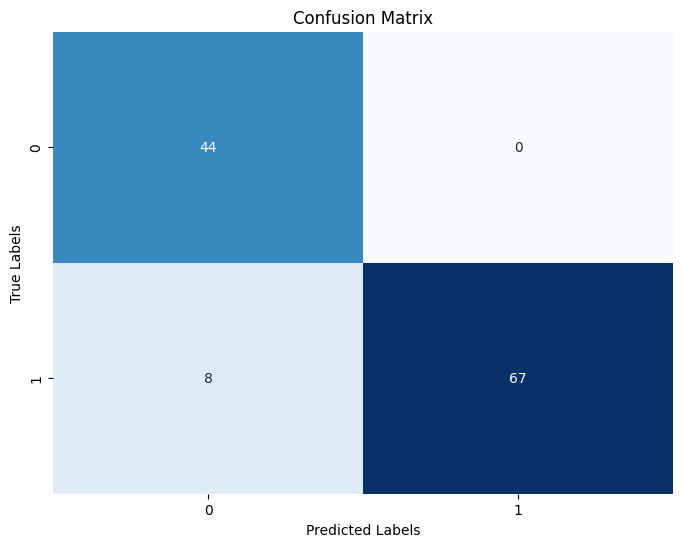



Fold 2:
8/8 [==============================] - 7s 722ms/step
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

      benign       0.85      1.00      0.92        44
   malignant       1.00      0.89      0.94        75

    accuracy                           0.93       119
   macro avg       0.92      0.95      0.93       119
weighted avg       0.94      0.93      0.93       119



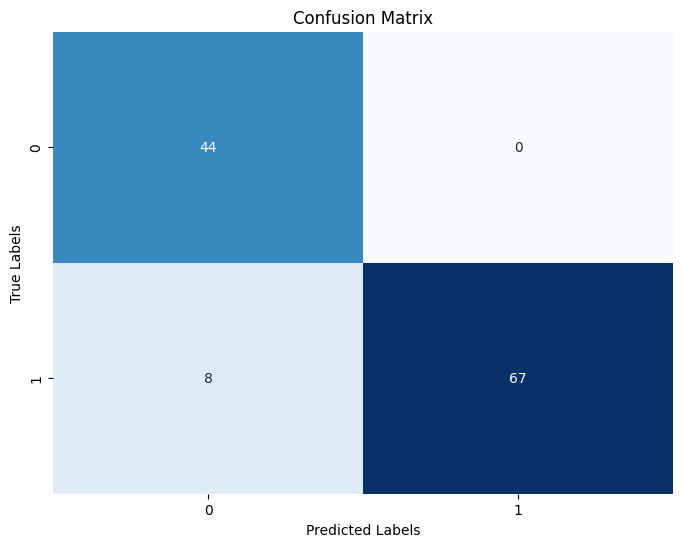



Fold 3:
8/8 [==============================] - 5s 535ms/step
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

      benign       0.86      1.00      0.93        44
   malignant       1.00      0.91      0.95        75

    accuracy                           0.94       119
   macro avg       0.93      0.95      0.94       119
weighted avg       0.95      0.94      0.94       119



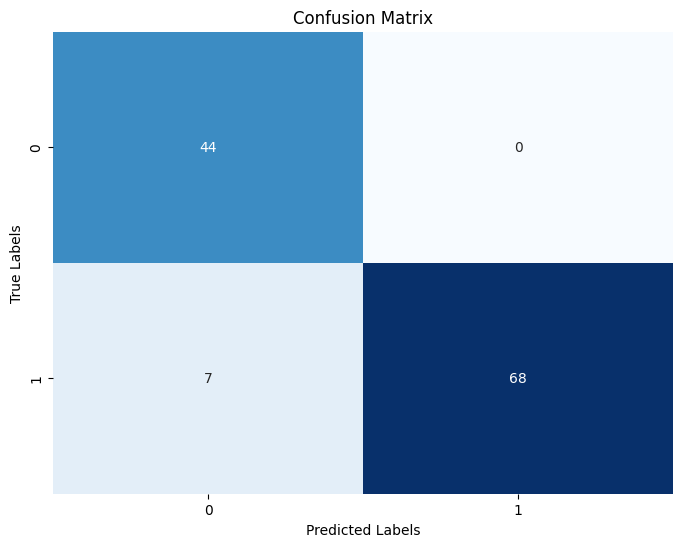



Fold 4:
8/8 [==============================] - 5s 621ms/step
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

      benign       0.90      1.00      0.95        44
   malignant       1.00      0.93      0.97        75

    accuracy                           0.96       119
   macro avg       0.95      0.97      0.96       119
weighted avg       0.96      0.96      0.96       119



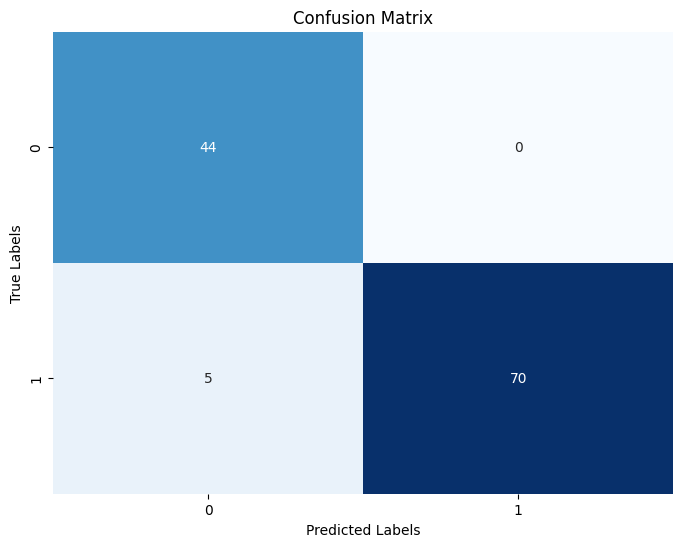



Fold 5:
8/8 [==============================] - 5s 519ms/step
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

      benign       0.92      1.00      0.96        44
   malignant       1.00      0.95      0.97        75

    accuracy                           0.97       119
   macro avg       0.96      0.97      0.96       119
weighted avg       0.97      0.97      0.97       119



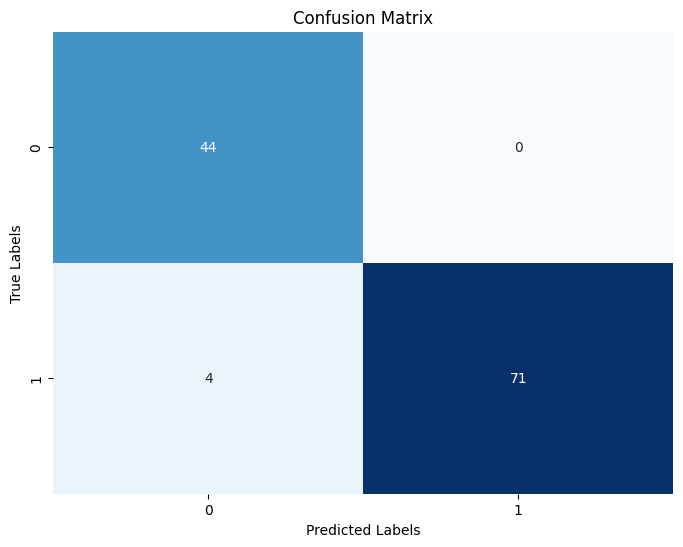

In [ ]:
evaluate_and_plot(histories_model_weights_breakhis, test_ds)

### Plot da curva ROC


8/8 [==============================] - 4s 551ms/step


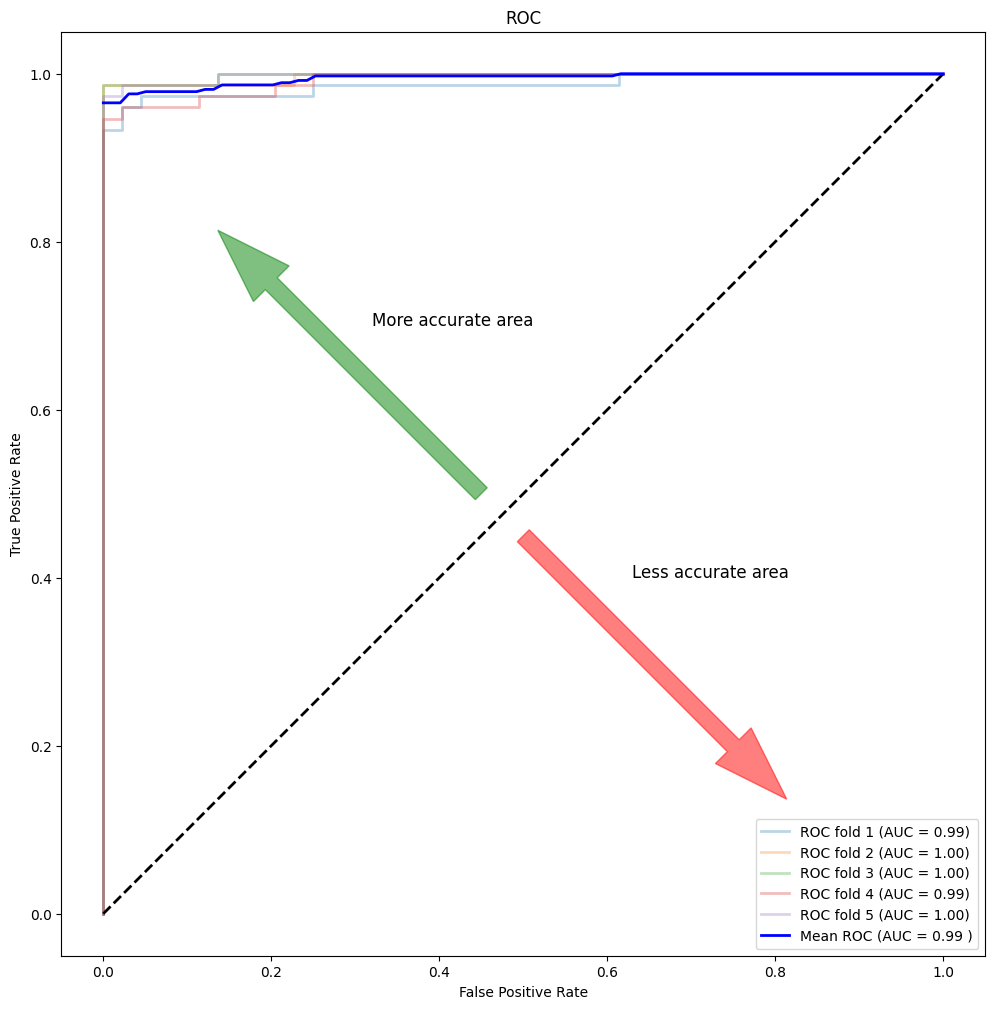

In [ ]:
plot_roc_curves(histories_model_weights_breakhis, test_ds)

## Comparação dos dois resultados em Curva ROC

8/8 [==============================] - 5s 661ms/step


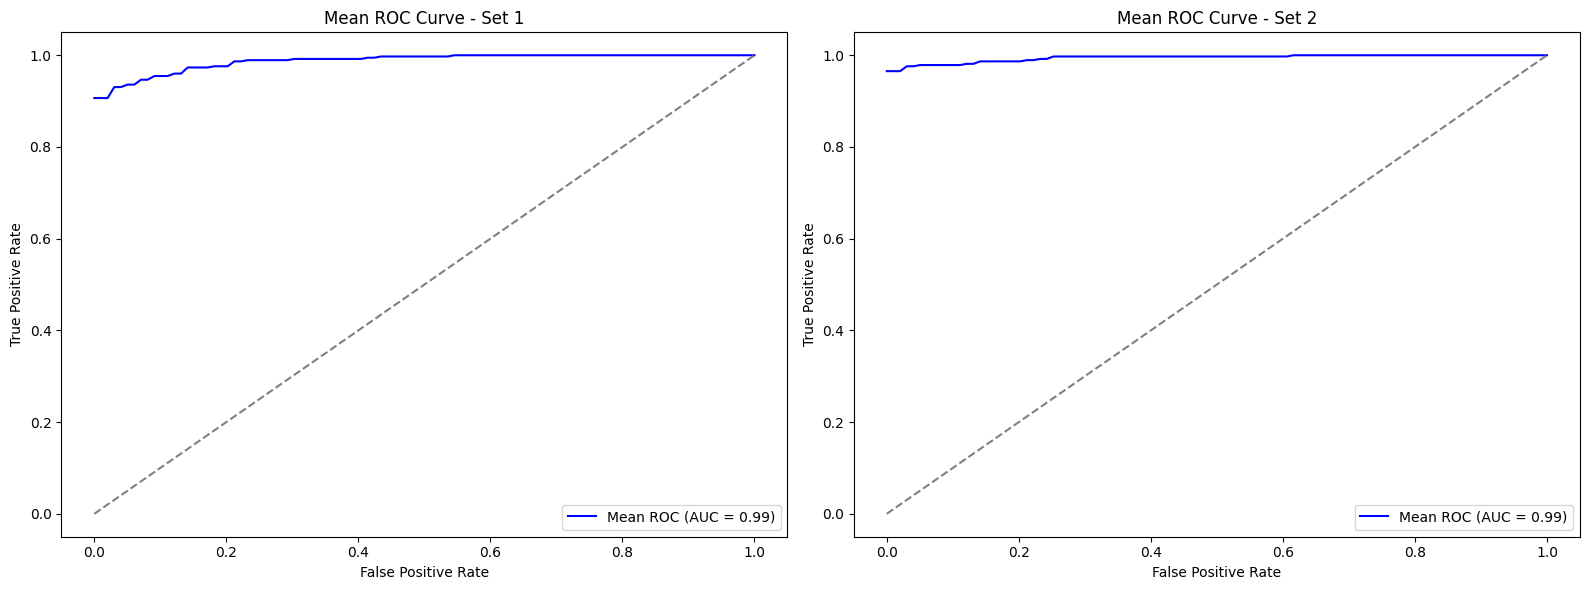

In [ ]:
def plot_mean_roc_media(histories_list, test_ds):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for i, histories in enumerate(histories_list):
        mean_fpr = np.linspace(0, 1, 100)
        tpr_sum = np.zeros(100)

        for history in histories:

            test_predictions = history.model.predict(test_ds)

            fpr, tpr, _ = roc_curve(test_ds.labels, test_predictions)
            tpr_sum += np.interp(mean_fpr, fpr, tpr)

        mean_tpr = tpr_sum / len(histories)

        mean_auc = auc(mean_fpr, mean_tpr)

        # Plotar a curva ROC média
        ax = axes[i]
        ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'Mean ROC Curve - Set {i+1}')
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


plot_mean_roc_media([histories_model_imagenet, histories_model_weights_breakhis], test_ds)

8/8 [==============================] - 4s 544ms/step


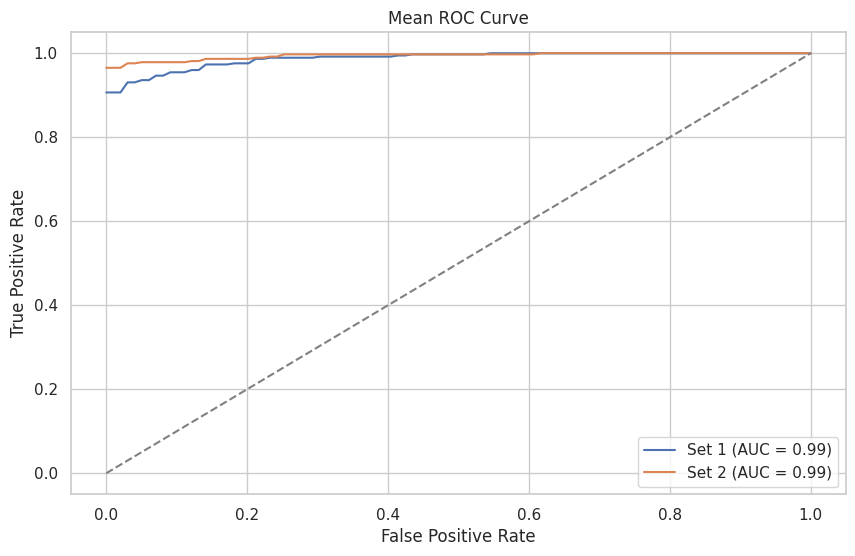

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def plot_mean_roc_media(histories_list, test_ds):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    for i, histories in enumerate(histories_list):
        mean_fpr = np.linspace(0, 1, 100)
        tpr_sum = np.zeros(100)

        for history in histories:
            test_predictions = history.model.predict(test_ds)
            fpr, tpr, _ = roc_curve(test_ds.labels, test_predictions)
            tpr_sum += np.interp(mean_fpr, fpr, tpr)

        mean_tpr = tpr_sum / len(histories)
        mean_auc = auc(mean_fpr, mean_tpr)

        plt.plot(mean_fpr, mean_tpr, label=f'Set {i+1} (AUC = {mean_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend()
    plt.show()

# Chama a função para plotar as curvas ROC médias
plot_mean_roc_media([histories_model_imagenet, histories_model_weights_breakhis], test_ds)


In [ ]:
from sklearn.metrics import accuracy_score

def calculate_average_accuracy(histories, test_ds):
    fold_accuracies = []

    for fold, history in enumerate(histories, start=1):
        # Prever as classes no conjunto de teste
        test_predictions = history.model.predict(test_ds)
        test_predictions_binary = (test_predictions > 0.5).astype(int)

        y_test = test_ds.labels

        accuracy = accuracy_score(y_test, test_predictions_binary)

        fold_accuracies.append(accuracy)

    avg_accuracy = np.mean(fold_accuracies)
    return avg_accuracy
accuracy_model1 = calculate_average_accuracy(histories_model_imagenet, test_ds)
accuracy_model2 = calculate_average_accuracy(histories_model_weights_breakhis, test_ds)
print('Sem pesos BreakHis:')
print(f"Accuracy: {accuracy_model1:.2f}")
print('Com pesos BreakHis:')
print(f"Accuracy: {accuracy_model2:.2f}")

8/8 [==============================] - 6s 707ms/step
Sem pesos BreakHis:
Accuracy: 0.89
Com pesos BreakHis:
Accuracy: 0.95
